**Задание light:**

Для базы GTZAN Genre Collection
1. Сделать классификацию с помощью полносвязной нейронной сети. Найти оптимальную архитектуру (количество слоев и нейронов) и оптимальный набор гипермапараметров (оптимизатор, размер мини-выборки, количество эпох и т.д.).
2. Используя библиотеку librosa (http://librosa.github.io/librosa/feature.html) поварьировать набор признаков, извлекаемых из аудио-файла. В качестве примера некоторые параметры можно вычислять не от всего файла длительностью 30 секунд, а от его частей, например длительностью 10 секунд. Также можно обратить внимание на количество mfcc коэффициентов.
3. (Опционально) Применить линейные модели (решающие деревья, градиентный бустинг) из библиотеки sklearn на полученном датасете, сделать ансамбль моделей из нейросети и линейных моделей.
 
**Задание pro:**
1. Выполните задание light.
2. Получите визуальные представления аудио файлов (возможно длительности менее 30 секунд).
3. Постройте модель классификации с использованием сверточных сетей. 
Удалось ли превзойти полносвязные сети?

In [0]:
from google.colab import drive
drive.mount('/content/drive')
#http://marsyas.info/downloads/datasets.html

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# feature extractoring and preprocessing data
import librosa
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#matplotlib inline
import os
import math
import PIL
from IPython.display import display
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing import image

#Keras
import keras
from keras import models
from keras import layers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

import warnings
warnings.filterwarnings('ignore')

def cv2_imshow(a):
  """A replacement for cv2.imshow() for use in Jupyter notebooks."""
  a = a.clip(0, 255).astype('uint8')
  # cv2 stores colors as BGR; convert to RGB
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

Using TensorFlow backend.


In [0]:
import zipfile
import io
z = zipfile.ZipFile('/content/drive/My Drive/genres.zip', 'r')
z.extractall()

In [0]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
p = '_pic'
for t in genres:
    path = f'genres/{t+p}'
    if not os.path.isdir(path):
        os.makedirs(path)

In [0]:
!ls genres  #/music

!zip -r -9 genres_pic.zip genres/*_pic


In [0]:
files.download('genres_pic.zip')

In [0]:
!ls genres/blues  #/music

##**Получение спектрограмм аудиофайлов**

In [0]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'genres/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'./genres/{g}'):
        songname = f'./genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'genres/{g+p}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

<Figure size 720x720 with 0 Axes>

In [0]:
!ls genres/country_pic 

(720, 720, 3)


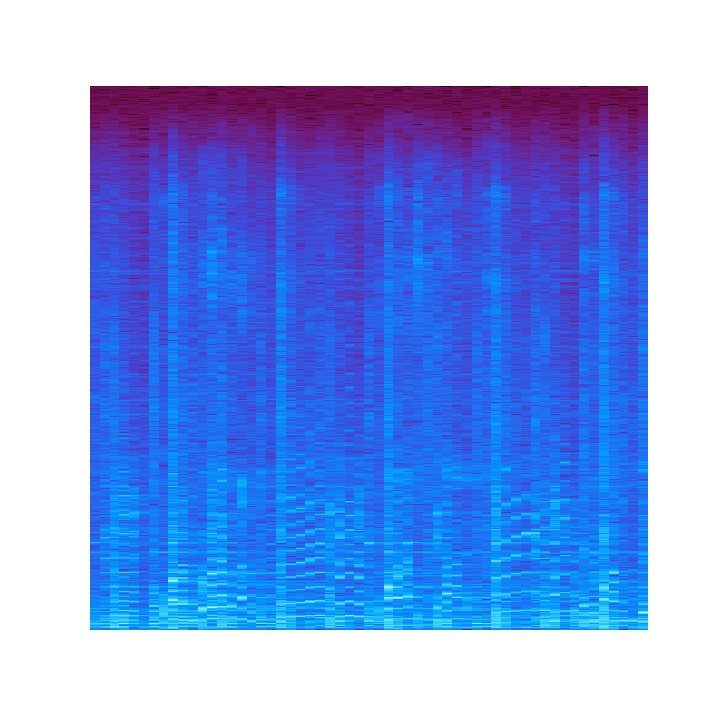

In [0]:
arr = image.load_img('genres/blues_pic/blues00000.png')
arr = image.img_to_array(arr)
print(arr.shape)
cv2_imshow(arr)

(720, 720, 3)


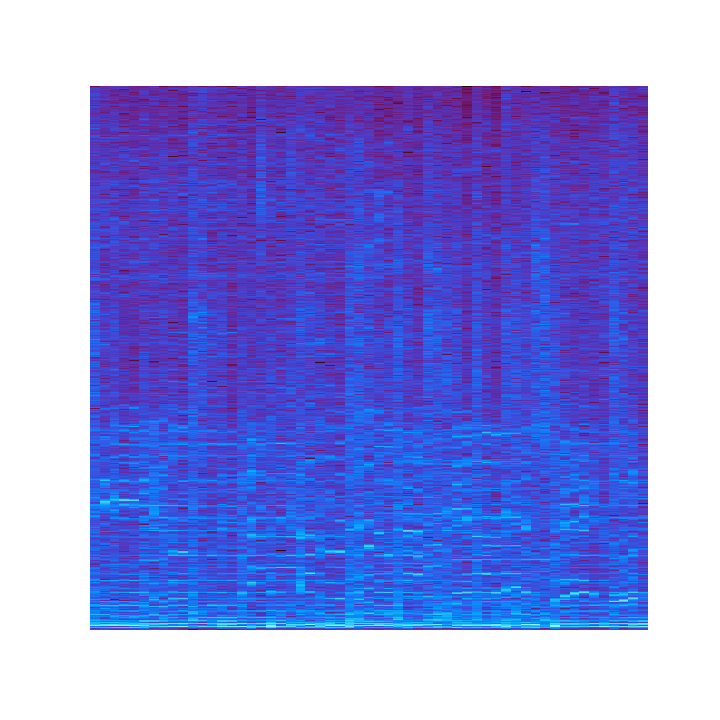

In [0]:
arr = image.load_img('genres/country_pic/country00001.png')
arr = image.img_to_array(arr)
print(arr.shape)
cv2_imshow(arr)

In [0]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

In [0]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
    
    
def get_features(y, sr):
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  rmse = librosa.feature.rmse(y=y)
  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
  zcr = librosa.feature.zero_crossing_rate(y)
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
  for e in mfcc:
    to_append += f' {np.mean(e)}'
  return to_append

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'./genres/{g}'):
        songname = f'./genres/{g}/{filename}'
        
        
        y, sr = librosa.load(songname, mono=True, duration=30)
        
        features = get_features(y, sr)
        features += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(features.split())

In [0]:
from google.colab import files
files.download("data.csv")

In [0]:
data = pd.read_csv('data.csv')
print(data.head())
print(len(data))

         filename  chroma_stft      rmse  ...    mfcc19    mfcc20  label
0  blues.00061.au     0.451905  0.141766  ... -8.363733 -6.978243  blues
1  blues.00028.au     0.275974  0.099696  ... -0.932405 -2.699273  blues
2  blues.00054.au     0.452728  0.200889  ... -5.422675 -2.582366  blues
3  blues.00006.au     0.291308  0.141796  ... -3.449033 -6.495511  blues
4  blues.00040.au     0.397725  0.134892  ... -4.856884  1.854516  blues

[5 rows x 28 columns]
1000


In [0]:
print(data.shape)
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

#Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

#Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

(1000, 28)


In [0]:
print(y_train)

[1 9 3 8 8 6 8 2 7 5 4 0 2 7 2 5 5 8 6 3 1 4 2 9 6 2 0 1 4 7 9 5 8 5 0 5 0
 9 7 8 1 7 8 2 4 8 4 9 6 9 9 7 4 0 6 0 9 0 1 1 9 1 4 2 9 1 3 5 3 8 3 0 6 3
 5 5 3 7 5 4 7 6 0 2 7 8 1 1 6 9 3 7 6 1 4 6 6 3 9 5 1 9 8 4 3 3 8 8 8 7 3
 6 8 0 9 6 6 6 5 7 8 7 0 1 7 2 1 0 0 4 6 3 0 1 0 3 2 0 0 7 5 6 7 9 3 6 8 8
 9 1 5 8 5 5 6 9 3 5 6 3 5 5 0 5 7 6 4 5 8 0 8 8 2 7 9 1 2 2 5 6 6 6 4 2 5
 1 4 1 7 5 6 2 4 5 0 4 7 2 7 6 0 0 5 1 8 0 6 9 3 1 1 6 4 8 9 4 4 9 1 6 1 4
 1 8 9 2 9 5 6 4 9 8 2 4 8 7 8 3 5 5 6 5 7 4 6 5 4 3 5 8 6 7 2 9 2 4 5 0 0
 2 6 1 0 4 4 8 6 7 4 7 7 7 2 5 0 9 3 8 8 6 6 5 5 5 1 8 6 4 8 4 9 5 0 7 2 9
 1 9 7 1 3 8 2 3 7 5 2 1 8 8 1 9 8 9 5 5 3 4 9 0 7 3 1 4 1 5 3 4 2 2 1 8 7
 4 4 2 0 6 2 5 8 1 0 8 8 6 9 9 2 7 5 1 0 7 9 0 1 6 4 1 5 3 4 2 9 5 4 8 3 3
 7 2 9 6 4 7 7 7 9 1 1 8 3 8 9 2 8 8 6 9 3 1 4 7 1 9 1 6 5 3 6 5 4 6 4 4 6
 8 0 3 1 0 3 6 3 2 7 0 8 2 4 6 6 7 0 3 1 3 3 9 0 0 6 8 8 7 9 9 2 7 7 4 8 2
 0 4 8 6 0 5 2 0 0 0 9 7 0 5 5 7 1 9 3 7 1 9 5 3 6 9 0 1 8 5 8 3 4 7 8 4 3
 3 6 1 5 5 0 1 8 0 0 2 2 

In [0]:
X_train[10]

array([ 0.72637998,  1.86012958, -0.53515741,  0.53069965, -0.36330435,
       -1.2501871 ,  0.26420816,  0.08743559,  1.36903096,  0.04303237,
        2.09092416, -0.57718145,  2.11977009, -1.11900636,  1.66359725,
       -1.07104263,  2.14342546, -0.44632304,  0.09281164,  0.2461546 ,
        1.00073873, -0.46632431, -0.33134826, -0.46995912, -0.50959679,
       -1.01886299])

In [0]:
X.shape

(1000, 26)

In [0]:
X_train.shape

(900, 26)

#FCN

In [0]:
from keras import models
from keras import layers

def create_model(units):
  model = models.Sequential()
  model.add(layers.Dense(units, activation='relu', input_shape=(X_train.shape[1],)))
  #model.add(layers.BatchNormalization())
  model.add(layers.Dropout(.1))
  model.add(layers.Dense(units//2, activation='relu'))
  #model.add(layers.BatchNormalization())
  model.add(layers.Dense(units//4, activation='relu'))
  model.add(layers.Dropout(.05))
  #model.add(layers.BatchNormalization())
  model.add(layers.Dropout(.01))
  model.add(layers.Dense(10, activation='softmax'))

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [0]:
256+128

384

In [0]:
model = create_model(256)
сheckpoint = ModelCheckpoint('au.hdf5', 
                                monitor='val_acc', 
                                save_best_only=True,
                                verbose=0)

def step_decay(epoch):
  initial_lrate = .01
  drop = 0.9
  epochs_drop = 3.0
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate    

lrate = LearningRateScheduler (step_decay) 

history = model.fit(X_train,
                    y_train,
                    validation_split=.1,
                    epochs=100,
                    batch_size=128,
                    callbacks=[сheckpoint, lrate])

Train on 810 samples, validate on 90 samples
Epoch 1/100
810/810 [==============================] - 7s 8ms/step - loss: 1.8227 - acc: 0.3333 - val_loss: 1.8125 - val_acc: 0.3222
Epoch 2/100
810/810 [==============================] - 0s 69us/step - loss: 1.3916 - acc: 0.4988 - val_loss: 1.5826 - val_acc: 0.4778
Epoch 3/100
810/810 [==============================] - 0s 62us/step - loss: 1.1135 - acc: 0.6123 - val_loss: 1.5914 - val_acc: 0.4556
Epoch 4/100
810/810 [==============================] - 0s 64us/step - loss: 0.9297 - acc: 0.6765 - val_loss: 1.5477 - val_acc: 0.5111
Epoch 5/100
810/810 [==============================] - 0s 75us/step - loss: 0.8024 - acc: 0.7148 - val_loss: 1.5349 - val_acc: 0.5444
Epoch 6/100
810/810 [==============================] - 0s 65us/step - loss: 0.7103 - acc: 0.7568 - val_loss: 1.4225 - val_acc: 0.5111
Epoch 7/100
810/810 [==============================] - 0s 61us/step - loss: 0.6588 - acc: 0.7679 - val_loss: 1.4854 - val_acc: 0.5333
Epoch 8/100
810/81

In [0]:
model.load_weights('au.hdf5')
model.evaluate(X_test,y_test)

100/100 [==============================] - 0s 109us/step


[1.3301319408416747, 0.76]

In [0]:
#!ls 
songname = 'genres/rock/rock.00000.au'
y, sr = librosa.load(songname, mono=True, duration=30)

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=sr/2)
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S))
S1 = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
mfcc1 = librosa.feature.mfcc(S=librosa.power_to_db(S1))

#mfcc2 = librosa.feature.mfcc(y=y, sr=sr)
mfcc3 = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)


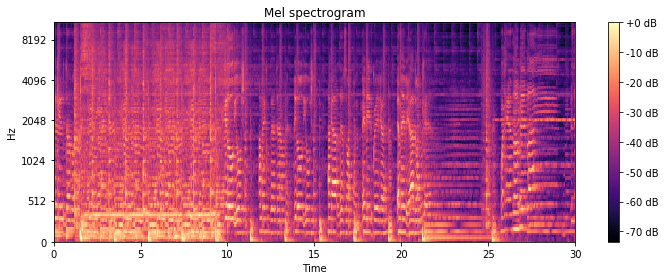

In [0]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),y_axis='mel', fmax=sr/2,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

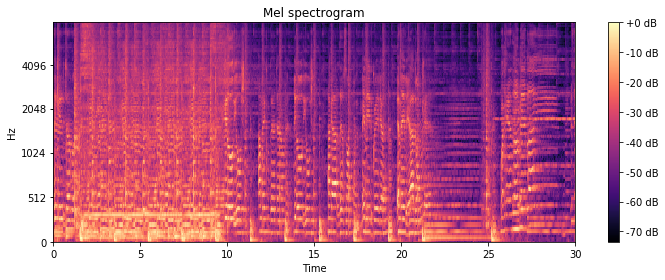

In [0]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

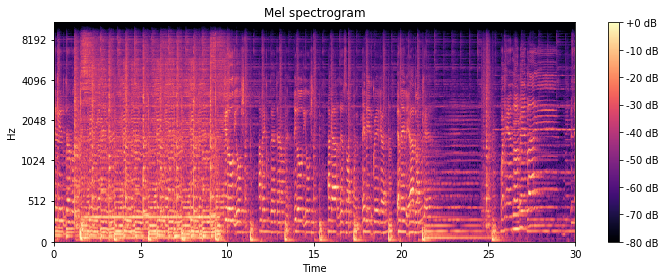

In [0]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, fmax=sr/2)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),y_axis='mel', fmax=sr/2,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [0]:
sr/2

11025.0

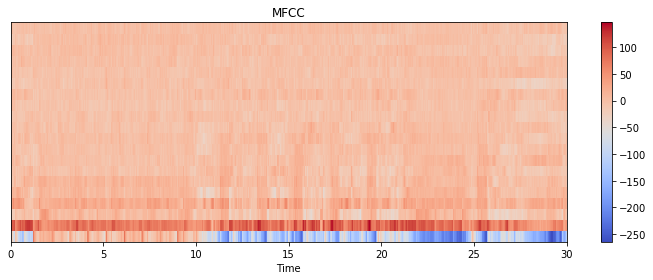

In [0]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

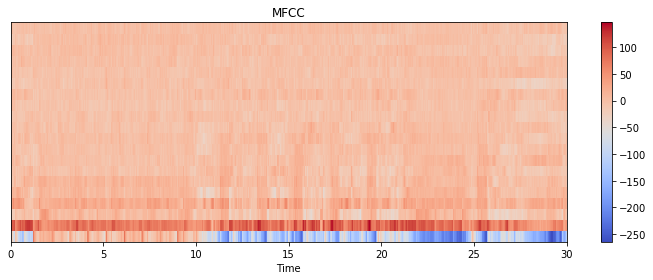

In [0]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc1, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [0]:
print(mfcc)
print(mfcc1)
#print(mfcc2)
print(mfcc3)

#Добавление признаков

In [0]:
mfcc.shape

(20, 1292)

In [0]:
#data_file = 'data_mels_256.csv'
data_file = 'data_nfcc_40_mnmx.csv'

header = 'filename mn_chroma_stft chroma_stft mx_chroma_stft mn_rmse rmse mx_rmse mn_spectral_centroid spectral_centroid mx_spectral_centroid mn_spectral_bandwidth spectral_bandwidth mx_spectral_bandwidth mn_rolloff rolloff mx_rolloff mn_zero_crossing_rate zero_crossing_rate mx_zero_crossing_rate'
for i in range(1, 41):
    header += f' mn_mfcc{i} mfcc{i} mx_mfcc{i}'
header += ' label'
header = header.split()
file = open(data_file, 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

In [0]:
file = open(data_file, 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
    
    
def get_features(y, sr):
  #Хроматограмма констант-Q
  #chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)
  #хроматограмма формы волны  
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  #среднеквадратичное (RMS) значение для каждого кадра
  rmse = librosa.feature.rmse(y=y)
  #спектральный центроид
  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
  #спектральная ширина полосы
  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
  #частота спада
  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
  #частота пересечения нуля звукового временного ряда
  zcr = librosa.feature.zero_crossing_rate(y)
  #Mel-частоты кепстральные коэффициенты (MFCCs)
  #mfcc = librosa.feature.mfcc(y=y, sr=sr)
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
  #S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, fmax=sr/2)
  #mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S))
  
  to_append = f'{filename} {np.min(chroma_stft)} {np.mean(chroma_stft)} {np.max(chroma_stft)} {np.min(rmse)} {np.mean(rmse)} {np.max(rmse)} {np.min(spec_cent)} {np.mean(spec_cent)} {np.max(spec_cent)} {np.min(spec_bw)} {np.mean(spec_bw)} {np.max(spec_bw)} {np.min(rolloff)} {np.mean(rolloff)} {np.max(rolloff)} {np.min(zcr)} {np.mean(zcr)} {np.max(zcr)}'    
  for e in mfcc:
    to_append += f' {np.min(e)} {np.mean(e)} {np.max(e)}'
  return to_append

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'./genres/{g}'):
        songname = f'./genres/{g}/{filename}'
        
        
        y, sr = librosa.load(songname, mono=True, duration=30)
        
        features = get_features(y, sr)
        features += f' {g}'
        file = open(data_file, 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(features.split())

In [0]:
from google.colab  import files
files.upload()

In [0]:
data_file = 'data_nfcc_40_mnmx.csv'
data = pd.read_csv(data_file)
print(data.head())
print(len(data))

         filename  mn_chroma_stft  chroma_stft  ...    mfcc40  mx_mfcc40  label
0  blues.00061.au        0.012356     0.451905  ...  1.502988  35.397375  blues
1  blues.00028.au        0.000490     0.275974  ... -4.434852  33.411711  blues
2  blues.00054.au        0.007739     0.452728  ... -2.664944  17.716403  blues
3  blues.00006.au        0.000199     0.291308  ...  5.262752  63.411359  blues
4  blues.00040.au        0.009797     0.397725  ... -5.240753  17.785952  blues

[5 rows x 140 columns]
1000


In [0]:
print(data.shape)
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

#Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

#Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

(1000, 140)


In [0]:
from keras import models
from keras import layers

def create_model(units):
  model = models.Sequential()
  model.add(layers.Dense(units, activation='relu', input_shape=(X_train.shape[1],)))
  #model.add(layers.BatchNormalization())
  model.add(layers.Dropout(.1))
  model.add(layers.Dense(units//2, activation='relu'))
  #model.add(layers.BatchNormalization())
  model.add(layers.Dense(units//4, activation='relu'))
  model.add(layers.Dropout(.05))
  #model.add(layers.BatchNormalization())
  model.add(layers.Dropout(.01))
  model.add(layers.Dense(10, activation='softmax'))

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [0]:
model = create_model(256)
сheckpoint = ModelCheckpoint('au.hdf5', 
                                monitor='val_acc', 
                                save_best_only=True,
                                verbose=0)

def step_decay(epoch):
  initial_lrate = .01
  drop = 0.95
  epochs_drop = 3.0
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate    

lrate = LearningRateScheduler (step_decay) 

history = model.fit(X_train,
                    y_train,
                    validation_split=.1,
                    epochs=100,
                    batch_size=128,
                    callbacks=[сheckpoint, lrate])

In [0]:
model.load_weights('au.hdf5')
model.evaluate(X_test,y_test)

100/100 [==============================] - 0s 95us/step


[1.034966640472412, 0.82]

#SVM

In [0]:
from sklearn import svm
import random
from sklearn import metrics
from sklearn.decomposition import PCA

def pca_transform(train_X,test_X,n_components=.99):
  pca = PCA(n_components=n_components)
  pca.fit(train_X)
  #преобразуем обучающую выборку
  pca_train_X = pca.transform(train_X)
  #преобразуем тестовую выборку
  pca_test_X = pca.transform(test_X)
  return(pca_train_X,pca_test_X)

gamma_range = [1e-5,1e-4,1e-3,1e-2,1e-1,1]
def tune_gamma(gamma_range,trainX,testX):
  classifiers = []
  for gamma in gamma_range:
    np.random.seed(42)
    random.seed(13)

    clf = svm.SVC(kernel = 'rbf', C=.9, gamma=gamma)
    clf.fit(trainX, y_train)
    y_predict = clf.predict(testX)
    acc = metrics.accuracy_score(y_test, y_predict)
    classifiers.append([gamma, acc])
  return classifiers

classifiers = tune_gamma(gamma_range,X_train,X_test)
X_pca_train,X_pca_test = pca_transform(X_train,X_test,n_components=.95)
pca_classifiers = tune_gamma(gamma_range,X_pca_train,X_pca_test)

In [0]:
print(classifiers)
print(pca_classifiers)

[[1e-05, 0.07], [0.0001, 0.3], [0.001, 0.71], [0.01, 0.77], [0.1, 0.13], [1, 0.1]]
[[1e-05, 0.07], [0.0001, 0.3], [0.001, 0.7], [0.01, 0.8], [0.1, 0.13], [1, 0.1]]


In [0]:
c_range = [.5,.9,1,2,3,4,5,7,8,10,20,30,50]
def tune_c(c_range,trainX,testX):
  classifiers = []
  for C in c_range:
    np.random.seed(42)
    random.seed(13)

    clf = svm.SVC(kernel = 'rbf', C=C, gamma=.01)
    clf.fit(trainX, y_train)
    y_predict = clf.predict(testX)
    acc = metrics.accuracy_score(y_test, y_predict)
    classifiers.append([C, acc])
  return classifiers


classifiers = tune_c(c_range,X_train,X_test)
pca_classifiers = tune_c(c_range,X_pca_train,X_pca_test)


In [0]:
print(classifiers)
print(pca_classifiers)
#res [param,acc]

[[0.5, 0.75], [0.9, 0.77], [1, 0.78], [2, 0.83], [3, 0.84], [4, 0.84], [5, 0.84], [7, 0.84], [8, 0.84], [10, 0.84], [20, 0.84], [30, 0.84], [50, 0.84]]
[[0.5, 0.74], [0.9, 0.8], [1, 0.8], [2, 0.82], [3, 0.84], [4, 0.83], [5, 0.83], [7, 0.83], [8, 0.83], [10, 0.83], [20, 0.83], [30, 0.83], [50, 0.83]]


#CNN

##Features

In [0]:
import zipfile
import io
z = zipfile.ZipFile('/content/drive/My Drive/genres.zip', 'r')
z.extractall()

In [0]:
import numpy as np
from tqdm import tqdm
import os
import librosa as lbr
import sys
from math import pi
from pickle import dump

TRACK_COUNT = 1000
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
WINDOW_SIZE = 2048
WINDOW_STRIDE = WINDOW_SIZE // 2
N_MELS = 128
MEL_KWARGS = {
    'n_fft': WINDOW_SIZE,
    'hop_length': WINDOW_STRIDE,
    'n_mels': N_MELS
}

def get_default_shape(dataset_path):
    tmp_features, _ = load_track(os.path.join(dataset_path,
        'blues/blues.00000.au'))
    return tmp_features.shape

  
def load_track(filename, enforce_shape=None):
    new_input, sample_rate = lbr.load(filename, mono=True)
    features = lbr.feature.melspectrogram(new_input, **MEL_KWARGS).T

    if enforce_shape is not None:
        if features.shape[0] < enforce_shape[0]:
            delta_shape = (enforce_shape[0] - features.shape[0],
                    enforce_shape[1])
            features = np.append(features, np.zeros(delta_shape), axis=0)
        elif features.shape[0] > enforce_shape[0]:
            features = features[: enforce_shape[0], :]

    features[features == 0] = 1e-6
    return (np.log(features), float(new_input.shape[0]) / sample_rate)
  
def collect_data(dataset_path):
    default_shape = get_default_shape(dataset_path)
    x = np.zeros((TRACK_COUNT,) + default_shape, dtype=np.float32)
    y = np.zeros((TRACK_COUNT, len(GENRES)), dtype=np.float32)
    track_paths = {}

    for (genre_index, genre_name) in tqdm(enumerate(GENRES)):
        for i in range(TRACK_COUNT // len(GENRES)):
            file_name = '{}/{}.000{}.au'.format(genre_name,
                    genre_name, str(i).zfill(2))
            print('Processing', file_name)
            path = os.path.join(dataset_path, file_name)
            track_index = genre_index  * (TRACK_COUNT // len(GENRES)) + i
            x[track_index], _ = load_track(path, default_shape)
            y[track_index, genre_index] = 1
            track_paths[track_index] = os.path.abspath(path)

    return (x, y, track_paths)  

In [0]:
(x, y, track_paths) = collect_data('genres')



In [0]:
data = {'x': x, 'y': y, 'track_paths': track_paths}
with open('genres_mel', 'wb') as f:
  dump(data, f)

In [0]:
#!cp genres_mel drive/My\ Drive/genres_mel.pickle

In [0]:
import pickle
with open('drive/My Drive/genres_mel.pickle', 'rb') as f:
  data = pickle.load(f)

##Model

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout, Activation, TimeDistributed, Convolution1D, MaxPooling1D, BatchNormalization
from sklearn.model_selection import train_test_split

SEED = 42
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 256
BATCH_SIZE = 32
EPOCH_COUNT = 100

x = data['x']
y = data['y']
(x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size=0.1, random_state=SEED)


n_features = x_train.shape[2]
input_shape = (None, n_features)
model_input = Input(input_shape, name='input')
layer = model_input
for i in range(N_LAYERS):
    layer = Convolution1D(
            filters=CONV_FILTER_COUNT,
            kernel_size=FILTER_LENGTH,
            name='convolution_' + str(i + 1)
        )(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling1D(2)(layer)
    layer = Dropout(0.5)(layer)

layer = TimeDistributed(Dense(len(GENRES)))(layer)
time_distributed_merge_layer = Lambda(
        function=lambda x: K.mean(x, axis=1), 
        output_shape=lambda shape: (shape[0],) + shape[2:],
        name='output_merged'
    )
layer = time_distributed_merge_layer(layer)
layer = Activation('softmax', name='output_realtime')(layer)
model_output = layer
model = Model(model_input, model_output)
opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, nb_epoch=EPOCH_COUNT,
        validation_split=.1,
        #validation_data=(x_val, y_val), verbose=1, 
        callbacks=[ModelCheckpoint('model.hdf5', save_best_only=True, monitor='val_acc', verbose=1),
          ReduceLROnPlateau(monitor='val_acc', factor=0.75, patience=5, min_delta=0.01,verbose=1) ]
)


W0729 06:20:49.244868 140471130552192 training.py:593] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 810 samples, validate on 90 samples
Epoch 1/100
800/810 [============================>.] - ETA: 0s - loss: 1.6772 - acc: 0.3900
Epoch 00001: val_acc improved from -inf to 0.42222, saving model to model.hdf5
810/810 [==============================] - 4s 5ms/sample - loss: 1.6800 - acc: 0.3889 - val_loss: 1.7023 - val_acc: 0.4222
Epoch 2/100
800/810 [============================>.] - ETA: 0s - loss: 1.1999 - acc: 0.5675
Epoch 00002: val_acc improved from 0.42222 to 0.52222, saving model to model.hdf5
810/810 [==============================] - 2s 2ms/sample - loss: 1.2149 - acc: 0.5642 - val_loss: 1.7302 - val_acc: 0.5222
Epoch 3/100
800/810 [============================>.] - ETA: 0s - loss: 1.1415 - acc: 0.5900
Epoch 00003: val_acc did not improve from 0.52222
810/810 [==============================] - 2s 2ms/sample - loss: 1.1420 - acc: 0.5877 - val_loss: 1.4595 - val_acc: 0.4667
Epoch 4/100
800/810 [============================>.] - ETA: 0s - loss: 0.9701 - acc: 0.6538
Epoch 0

0.8


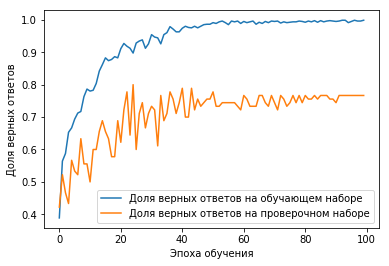

In [32]:
import matplotlib.pyplot as plt

print(np.max(history.history['val_acc']))

plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

##Test

In [33]:
model.load_weights('model.hdf5')
model.evaluate(x_test,y_test)

100/100 [==============================] - 0s 1ms/sample - loss: 0.7777 - acc: 0.7800


[0.7776755571365357, 0.78]

#Вывод

[colab](https://colab.research.google.com/drive/1E-ekl6DGpquiOLNIpGjM78n7qOXnZBXJ)

Добавление к базовой модели (полносвязная сеть) Dropout и LearningRateScheduler, увеличило точность на тесте до 76%, увеличение фичей fmcc до 40 параметров, а также добавив min и max фичей добавило точности до 82%. SVM классификатор 84%. На сверточной сети точность полносвязной сети превысить не удалось,  точность на тесте 78%.